In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv(key='GROQ_API_KEY')

from langchain_groq import ChatGroq
llm=ChatGroq(model='gemma2-9b-it')
llm.invoke('Hello').content

'Hello! 👋\n\nHow can I help you today? 😄\n'

In [2]:
from pydantic import BaseModel,Field
from typing import Literal

class Reviewer(BaseModel):
    status:Literal['Approved','Rejected + Feedback']
    feedback:str

In [3]:
from typing_extensions import TypedDict

class State(TypedDict):
    topic:str 
    source_code:str
    code_review_status:str 
    test_cases:str 
    test_case_review_status:str 
    manager_approval_status:str
    feedback:str
    final_code_version:str
    deployment_status:str

In [4]:
from langchain_core.messages import SystemMessage,HumanMessage,AIMessage


def code_writer(state: State):
    '''Writes code based on the user input'''
    
    topic = state.get('topic')
    feedback = state.get('feedback')
    
    if feedback:
        response = llm.invoke([
            SystemMessage(content=f'You are an expert in writing code in all programming languages. Develop a code based on the user input and take into account the feedback: {feedback}.'),
            HumanMessage(content=f"Here is the user input: {topic}")
        ])
    else:
        response = llm.invoke([
            SystemMessage(content='You are an expert in writing code in all programming languages. Develop a code based on the user input.'),
            HumanMessage(content=f"Here is the user input: {topic}")
        ])

    return {'source_code': response.content}


def code_reviewer(state: State):
    """Reviews the code and provides feedback."""
    
    source_code = state.get('source_code')
    
    reviewer = llm.with_structured_output(Reviewer)
    
    if source_code:
        response = reviewer.invoke([
                SystemMessage(content='You are an expert in reviewing code in all programming languages. Review the following code and provide approval and feedback.'),
                HumanMessage(content=f"Here is the code:\n\n{source_code}")       
               ])

        return {
                 'code_review_status': response.status,
                 'feedback': response.feedback
               }
    
def test_case_generator(state: State):
    """Generates test cases for the given code and user input."""
    
    user_input = state.get('topic')
    source_code = state.get('source_code')    

    if source_code and user_input:
        response = llm.invoke([
                             SystemMessage(content="You are an expert in generating test cases for all programming languages. Generate test cases for the given code and user input."),
                             HumanMessage(content=f"Here is the code:\n\n{source_code}\n\nUser Input: {user_input}")
                              ])
 
    return {'test_cases': response.content}

def test_case_reviewer(state: State):
    """Reviews the generated test cases and verifies them against the provided source code."""
    
    user_input = state.get('topic')
    source_code = state.get('source_code')
    test_cases = state.get('test_cases')    

    reviewer = llm.with_structured_output(Reviewer)
    
    if user_input and source_code and test_cases:
        response = reviewer.invoke([
            SystemMessage(content="You are an expert in reviewing test cases for all programming languages. Review the given code, verify the test cases, and provide your approval along with detailed feedback."),
            HumanMessage(content=f"User Input:\n{user_input}\n\nSource Code:\n{source_code}\n\nTest Cases:\n{test_cases}")
                  ])

        return {
               'test_case_review_status': response.status,
               'feedback': response.feedback
            }


def manager(state:State):
    '''Manager needts to provdie the approval for PROD deployment'''
    while True:
        choice=input("Enter your approval (Approved/Rejected + Feedback'):")
        if choice not in ['Approved','Rejected + Feedback']:
            print('Inavlid value. pls select the correct value')
            continue

        feedback=None  
        if choice=='Rejected + Feedback':
            feedback=input("Enter your Feedback':")


        return {'manager_approval_status':choice,'feedback':feedback,'final_code_version':state.get('source_code'),'deployment_status':'LIVE'} if choice=='Approved' else {'manager_approval_status':choice,'feedback':feedback}  


def reviewer_status(state:State):
    return state.get('code_review_status')

def test_case_reviewer_status(state:State):
    return state.get('test_case_review_status')

def manager_status(state:State):
    return state.get('manager_approval_status')


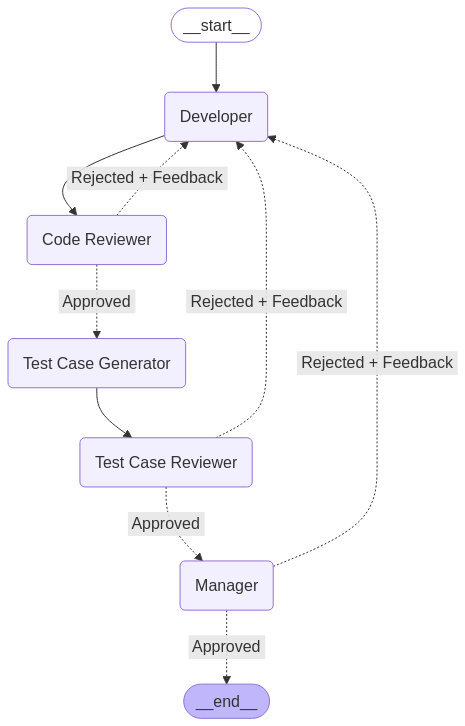

In [5]:
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display
from langgraph.checkpoint.memory import MemorySaver

# Build the workflow
workflow=StateGraph(State)

# define the nodes
workflow.add_node('Developer',code_writer)
workflow.add_node('Code Reviewer',code_reviewer)
workflow.add_node('Test Case Generator',test_case_generator)
workflow.add_node('Test Case Reviewer',test_case_reviewer)
workflow.add_node('Manager',manager)

# define the edges
workflow.add_edge(START,'Developer')
workflow.add_edge('Developer','Code Reviewer')
workflow.add_conditional_edges('Code Reviewer',reviewer_status,{'Approved':'Test Case Generator','Rejected + Feedback':'Developer'})
workflow.add_edge('Test Case Generator','Test Case Reviewer')
workflow.add_conditional_edges('Test Case Reviewer',test_case_reviewer_status,{'Approved':'Manager','Rejected + Feedback':'Developer'})
workflow.add_conditional_edges('Manager',manager_status,{'Approved':END,'Rejected + Feedback':'Developer'})

memory=MemorySaver()

code_peer_review=workflow.compile(checkpointer=memory)

#view
display(Image(code_peer_review.get_graph().draw_mermaid_png()))


In [6]:
config={'configurable':{'thread_id':'1'}}
response=code_peer_review.invoke(input={'topic':'Write a PLSQL Code to call the concurrent program'},config=config)


In [7]:
response

{'topic': 'Write a PLSQL Code to call the concurrent program',
 'source_code': "```sql\nDECLARE\n  program_name VARCHAR2(30);  -- Replace with the actual concurrent program name\nBEGIN\n  \n  program_name := 'YOUR_CONCURRENT_PROGRAM_NAME'; -- Replace with your program name\n\n  -- Call the concurrent program\n  DBMS_SCHEDULER.RUN_PROGRAM(\n    program_name => program_name,\n    user_id => 'YOUR_USER_ID',  -- Replace with your user ID\n    arguments => NULL --  Optional: pass arguments to the program\n  );\n\n  DBMS_OUTPUT.PUT_LINE('Concurrent program ' || program_name || ' scheduled.');\nEND;\n/\n```\n\n**Explanation:**\n\n1. **Declare Variables:**\n   - `program_name`: Stores the name of the concurrent program you want to call. **Replace 'YOUR_CONCURRENT_PROGRAM_NAME' with the actual name of your program.**\n   -  `user_id`:  Replace 'YOUR_USER_ID' with the user ID that has the necessary permissions to run the concurrent program. \n\n2. **Call `DBMS_SCHEDULER.RUN_PROGRAM`:**\n   - Thi

In [8]:
from IPython.display import Markdown
Markdown(response['final_code_version'])

```sql
DECLARE
  program_name VARCHAR2(30);  -- Replace with the actual concurrent program name
BEGIN
  
  program_name := 'YOUR_CONCURRENT_PROGRAM_NAME'; -- Replace with your program name

  -- Call the concurrent program
  DBMS_SCHEDULER.RUN_PROGRAM(
    program_name => program_name,
    user_id => 'YOUR_USER_ID',  -- Replace with your user ID
    arguments => NULL --  Optional: pass arguments to the program
  );

  DBMS_OUTPUT.PUT_LINE('Concurrent program ' || program_name || ' scheduled.');
END;
/
```

**Explanation:**

1. **Declare Variables:**
   - `program_name`: Stores the name of the concurrent program you want to call. **Replace 'YOUR_CONCURRENT_PROGRAM_NAME' with the actual name of your program.**
   -  `user_id`:  Replace 'YOUR_USER_ID' with the user ID that has the necessary permissions to run the concurrent program. 

2. **Call `DBMS_SCHEDULER.RUN_PROGRAM`:**
   - This procedure allows you to execute concurrent programs.
   - `program_name`: Passes the name of the concurrent program.
   - `user_id`: Specifies the user who will run the program.
   - `arguments`: (Optional) Allows you to pass arguments to the concurrent program. If your program doesn't require arguments, set this to `NULL`.

3. **Output Confirmation:**
   - The code uses `DBMS_OUTPUT.PUT_LINE` to display a confirmation message that the concurrent program has been scheduled.

**Important Notes:**

- **Permissions:** The user executing this code must have the necessary privileges to run concurrent programs.
- **Concurrent Program Setup:** Ensure that your concurrent program is properly defined and configured in Oracle Applications.
- **Arguments:** Consult your program's documentation to understand if and how to pass arguments.



Let me know if you have any other questions or need help with a specific program!
